In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from control.modules.thrusters import ThrustersAlarms, ThrustersControl, ThrustersParameters
from input_output.base import Stamped, StampedDf
from input_output.definitions.simulation import Boundary, Pcs, TemperatureBoundary, Thruster
from input_output.modules.thrusters import ThrustersControlValues, ThrustersSensorValues, ThrustersSimulationInputs, ThrustersSimulationOutputs
from orchestration.simulator import Simulator, SimulatorModel
import polars as pl

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=59)

supply_temperature = StampedDf.stamp(pl.DataFrame({'time':pl.datetime_range(start_time, start_time + duration, interval ='1m', time_unit = "us", eager=True), 'value':30*[50.0] + 30*[80.0]}))

simulation_inputs = ThrustersSimulationInputs(
    thrusters_aft=Thruster(heat_flow=Stamped.stamp(9000.0), active=Stamped.stamp(True)),
    thrusters_fwd=Thruster(heat_flow=Stamped.stamp(4300.0), active=Stamped.stamp(True)),
    thrusters_seawater_supply=Boundary(
        temperature=Stamped.stamp(32.0), flow=Stamped.stamp(64.0)),
    thrusters_module_supply=TemperatureBoundary(temperature=supply_temperature),
    thrusters_pcs=Pcs(mode=Stamped.stamp("propulsion")),
    )

control = ThrustersControl(ThrustersParameters(cooling_mix_setpoint=40, recovery_thruster_flow=10, cooling_thruster_flow=22, max_temp=70, recovery_mix_setpoint=60))
control.to_recovery()

thrusters_model = SimulatorModel(
    fmu_path=str(
        "../src/simulation/models/thrusters/thruster_moduleV10_1.fmu"
    ),
    sensor_values_cls=ThrustersSensorValues,
    control_values_cls=ThrustersControlValues,
    simulation_outputs_cls=ThrustersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control = control,
    alarms=ThrustersAlarms(),
    tick_duration = timedelta(seconds = 1),
    start_time=start_time)

simulation = Simulator(thrusters_model)

result = await simulation.run(6*60)


[WARNING] Warning: The following was detected at time: 4.632291098981836E-26
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_mixing_return: Flow splitRatio is far above 1. But it must be between 0 and 1. (is 1.00479)
  Failed condition: thrusterModule.flowJoin_mixing_return.splitRatio <= 1.001

[WARNING] Warning: The following was detected at time: 1.940263428176179E-23
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_thruster_out: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -3.30264e+15)
  Failed condition: thrusterModule.flowJoin_thruster_out.splitRatio >= -0.001

[WARNING] Warning: The following was detected at time: 1.479515762243391E-10
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_AFT: Flow splitRatio is far above 1. But it must be between 0 and 1. (is 1.001)
  Failed condition: thrusterModule.flowJoin_AFT.splitRatio <= 1.001

[WARNING] Warning: The following was detected at time: 6.308247101777696E-08
[WARNING]   Thru

In [3]:
#simulate scenario: start in recovery, increase thrusters source (trigger warm-up mixing), increase seawater temp (trigger cooling mode)
#collect control modes and plot
#collect simulation inputs and plot

#look up mixture and its specific heat capacity

In [4]:
import polars as pl

from analysis.analysis_utils import compute_heat



df = result.group_by_dynamic("time", every="1m").agg([
    pl.col("*").mean()
])

# Add new columns for heat calculations
heat = pl.DataFrame({"thrusters_heat_recovered":
    compute_heat(
        df["thrusters_module_return__temperature__C"],
        df["thrusters_module_supply__temperature__C"],
        df["thrusters_module_supply__flow__l_min"]
    ),
    "thrusters_heat_dumped" :compute_heat(
        df["thrusters_seawater_return__temperature__C"],
        df["thrusters_seawater_supply__temperature__C"],
        df["thrusters_seawater_supply__flow__l_min"]
    ),
    "thrusters_aft_heat":compute_heat(
        df["thrusters_temperature_aft_return__temperature__C"],
        df["thrusters_temperature_supply__temperature__C"],
        df["thrusters_flow_aft__flow__l_min"]
    ),
    "thrusters_fwd_heat":compute_heat(
        df["thrusters_temperature_fwd_return__temperature__C"],
        df["thrusters_temperature_supply__temperature__C"],
        df["thrusters_flow_fwd__flow__l_min"]
    )
})

heat_df = heat.with_columns(df['time']).to_pandas().set_index('time')
temp_df = df.select([col for col in df.columns if "__temperature__" in col or col=="time"]).to_pandas().set_index('time')
flow_df = df.select([col for col in df.columns if "__flow__" in col or col=="time"]).to_pandas().set_index('time')
valve_df = df.select([col for col in df.columns if ("__position_rel__" in col and 'mix' in col) or col=="time"]).to_pandas().set_index('time')

(<Figure size 1000x800 with 4 Axes>,
 array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object))

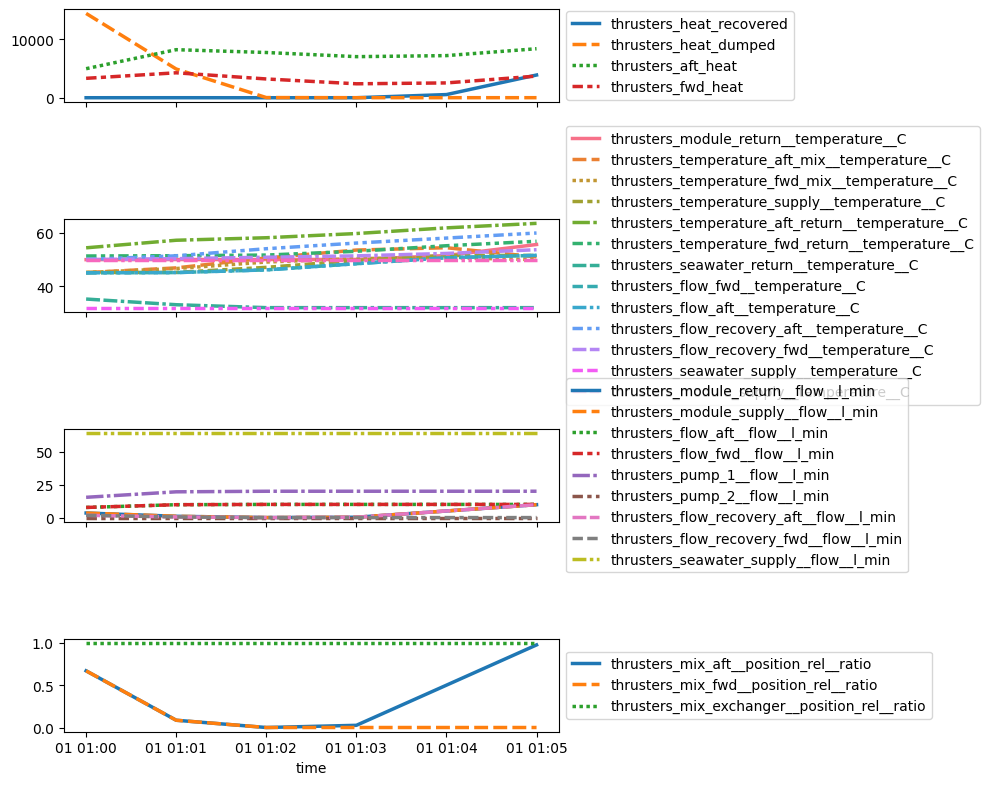

In [5]:
from analysis.analysis_utils import plot_frames


frames = [heat_df, temp_df, flow_df, valve_df]

plot_frames(frames, "plots/thrusters_plot.png")